## Autoencoder for Earthquake triggered ground motion using fourier spectral amplitudes

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import math

### read and prepare data

In [2]:
data_all = pd.read_csv('ESM_flatfile_FAS.csv',sep = ';', low_memory=False)

Select the columns with Fourier spectral amplitudes and reduce the two horizontal components to one value. Remove records with nan-values.

In [3]:
## get labels of columns with FAS values
FAS_U_labels = [x for x in data_all.columns if 'U_F' in x]
FAS_V_labels = [x for x in data_all.columns if 'V_F' in x]
FAS_W_labels = [x for x in data_all.columns if 'W_F' in x]

## get the values of considered frequencies
frequencies  = [float(x[3:].replace("_", ".")) for x in FAS_U_labels]

## taking root mean squared values of horizontal components
FAS_h = np.sqrt((np.asarray(data_all[FAS_U_labels])**2 + 
                 np.asarray(data_all[FAS_V_labels])**2)/2 )

## data set with horizontal and vertical component
FAS = np.concatenate((FAS_h, np.asarray(data_all[FAS_W_labels])), axis=1)

## remove nan's
nan_rows = list(set(np.where(np.isnan(FAS))[0]))
FAS = np.delete(FAS, nan_rows, 0)

print("Data set dimension:", FAS.shape)

Data set dimension: (22643, 206)


#### Define training and test data.
The test and validation set include each about 1/10 of all data. The remaining data are used for training.

In [4]:
batch_size = 128

n_data     = FAS.shape[0]
n_train    = math.ceil(n_data*8/10/batch_size)*batch_size
n_test     = math.ceil((n_data - n_train)/2)
n_val      = n_data - n_train - n_test

eps = 10**(-8)
data_train = np.log10(FAS[ :n_train]+eps)
data_test  = np.log10(FAS[n_train:(n_train+n_test)]+eps)
data_val   = np.log10(FAS[(n_train+n_test):]+eps)

## shuffle ground motion records in the training data to destroy order,
## e.g. subsequent records of the same earthquake recorded at different stations
np.random.shuffle(data_train)

Plot frequency spectrum for 10 records for data visualization.

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


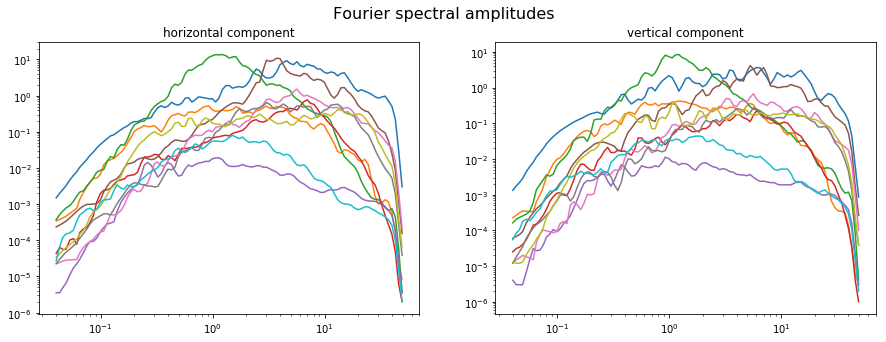

In [5]:
n_freq = len(frequencies)

fig = plt.figure(1, figsize=(15, 5))
fig.suptitle("Fourier spectral amplitudes", fontsize = 16)
for i in range(10):
  plt.subplot(121)
  plt.loglog(frequencies, np.power(10, data_train[i,:n_freq]))
  plt.title("horizontal component")

  plt.subplot(122)
  plt.loglog(frequencies, np.power(10, data_train[i,n_freq:]))
  plt.title("vertical component")

plt.show()

In [26]:
## tf data set
# dataset = tf.data.Dataset.from_tensor_slices(np_data)
# dataset = dataset.shuffle(1000).repeat().batch(batch_size)
# next_element = dataset.make_one_shot_iterator().get_next()
# print(next_element)

### Construct Autoencoder

In [6]:
n_inputs  = data_train.shape[1]
n_outputs = n_inputs
n_hidden1 = 64
n_hidden2 = 16  # bottleneck
n_hidden3 = n_hidden1

Autoencoder with L2 regularization

In [7]:
learning_rate = 0.01
l2_reg = 0.001
from functools import partial

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.relu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(inputs,  n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)
reconstruction_loss = tf.reduce_mean(tf.square(outputs - inputs)) # MSE

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [8]:
with tf.Session() as sess:
    init.run()
    data_shuffle = data_train
    cur_pos = 0 # used to iterate over batches
#    batch_iterator = dataset.make_one_shot_iterator()
    for i in range(1000):
        if cur_pos + batch_size > n_train:
            np.random.shuffle(data_shuffle)
            cur_pos = 0            
#        batch_x = batch_iterator.get_next()
        sess.run(training_op, feed_dict={inputs: data_shuffle[cur_pos:(cur_pos + batch_size),]})
        if i % 100 == 0:
#        if i in range(100):
            train_loss = loss.eval(feed_dict={inputs: data_shuffle[cur_pos:(cur_pos + batch_size),]})
            test_loss = loss.eval(feed_dict={inputs: data_test[0:batch_size,]})
            print('step %d: training loss = %g, test loss: %g' % (i, train_loss, test_loss))
        cur_pos += batch_size
    output_values = outputs.eval(feed_dict = {inputs: data_test[:10,]})

step 0: training loss = 6.14356, test loss: 3.93673
step 100: training loss = 0.493383, test loss: 0.621183
step 200: training loss = 0.401806, test loss: 0.530622
step 300: training loss = 0.177665, test loss: 0.183205
step 400: training loss = 0.147513, test loss: 0.152655
step 500: training loss = 0.127051, test loss: 0.136177
step 600: training loss = 0.112855, test loss: 0.122763
step 700: training loss = 0.109089, test loss: 0.107226
step 800: training loss = 0.0960953, test loss: 0.103485
step 900: training loss = 0.0917168, test loss: 0.0965886


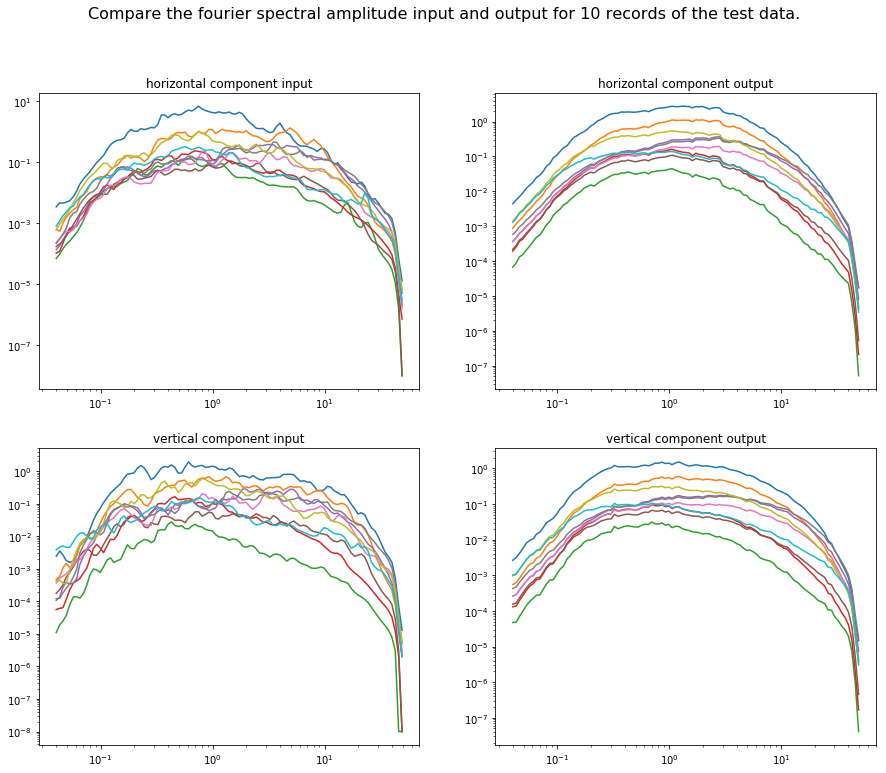

In [9]:
fig = plt.figure(1, figsize=(15, 12))
fig.suptitle("Compare the fourier spectral amplitude input and output for 10 records of the test data.", fontsize = 16)
for i in range(10):
  plt.subplot(221)
  plt.loglog(frequencies, np.power(10, data_test[i,:n_freq]))
  plt.title("horizontal component input")

  plt.subplot(222)
  plt.loglog(frequencies, np.power(10, output_values[i,:n_freq]))
  plt.title("horizontal component output")

  plt.subplot(223)
  plt.loglog(frequencies, np.power(10, data_test[i,n_freq:]))
  plt.title("vertical component input")

  plt.subplot(224)
  plt.loglog(frequencies, np.power(10, output_values[i,n_freq:]))
  plt.title("vertical component output")

plt.show()